<a href="https://colab.research.google.com/github/TJConnellyContingentMacro/MachineLearningBasics/blob/master/FOMCWebScraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title  { form-width: "50px" }
from __future__ import print_function
from bs4 import BeautifulSoup
from urllib.request import urlopen
import re
import pandas as pd
import pickle
import threading
import sys

class FOMC (object):
    '''
    A class for extracting meeting minutes from the FOMC website
    '''

    def __init__(self, base_url='https://www.federalreserve.gov', 
                 calendar_url='https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm',
                 historical_date = 2011,
                 verbose = True,
                 max_threads = 2):

        self.base_url = base_url
        self.calendar_url = calendar_url
        self.df = None
        self.links = None
        self.dates = None
        self.articles = None
        self.verbose = verbose
        self.HISTORICAL_DATE = historical_date
        self.MAX_THREADS = max_threads
    

    def _get_links(self, from_year):
        '''
        private function that sets all the links for the FOMC meetings from the giving from_year
        to the current most recent year
        '''
        if self.verbose:
            print("Getting links...")
        self.links = []
        fomc_meetings_socket = urlopen(self.calendar_url)
        soup = BeautifulSoup(fomc_meetings_socket, 'html.parser')

        statements = soup.find_all('a', href=re.compile('^/newsevents/pressreleases/monetary\d{8}a.htm'))
        self.links = [statement.attrs['href'] for statement in statements] 

        if from_year <= self.HISTORICAL_DATE:        
            for year in range(from_year, self.HISTORICAL_DATE + 1):
                fomc_yearly_url = self.base_url + '/monetarypolicy/fomchistorical' + str(year) + '.htm'
                fomc_yearly_socket = urlopen(fomc_yearly_url)
                soup_yearly = BeautifulSoup(fomc_yearly_socket, 'html.parser')
                statements_historical = soup_yearly.findAll('a', text = 'Statement')
                for statement_historical in statements_historical:
                    self.links.append(statement_historical.attrs['href'])


    def _date_from_link(self, link):
        date = re.findall('[0-9]{8}', link)[0]
        if date[4] == '0':
            date = "{}/{}/{}".format(date[:4], date[5:6], date[6:])
        else:
            date = "{}/{}/{}".format(date[:4], date[4:6], date[6:])
        return date


    def _add_article(self, link, index=None):
        '''
        adds the related article for 1 link into the instance variable
        index is the index in the article to add to. Due to concurrent
        processing, we need to make sure the articles are stored in the
        right order
        '''
        if self.verbose:
            sys.stdout.write(".")
            sys.stdout.flush()

        # date of the article content
        self.dates.append(self._date_from_link(link))
        statement_socket = urlopen(self.base_url + link)
        statement = BeautifulSoup(statement_socket, 'html.parser')
        paragraphs = statement.findAll('p')
        self.articles[index]= "\n\n".join([paragraph.get_text().strip() for paragraph in paragraphs])


    def _get_articles_multi_threaded(self):
        '''
        gets all articles using multi-threading
        '''
        if self.verbose:
            print("Getting articles - Multi-threaded...")

        self.dates, self.articles = [], ['']*len(self.links)
        jobs = []
        # initiate and start threads:
        index = 0
        while index < len(self.links):
            if len(jobs) < self.MAX_THREADS:
                t = threading.Thread(target=self._add_article, args=(self.links[index],index,))
                jobs.append(t)
                t.start()
                index += 1
            else:    # wait for threads to complete and join them back into the main thread
                t = jobs.pop(0)
                t.join()
        for t in jobs:
            t.join()

        for row in range(len(self.articles)):
            self.articles[row] = self.articles[row].strip()


    def get_statements(self, from_year=1994):
        '''
        Returns a Pandas DataFrame of meeting minutes with the date as the index
        uses a date range of from_year to the most current
        Input from_year is ignored if it is within the last 5 years as this is meant for 
        parsing much older years
        '''
        self._get_links(from_year)
        print("There are", len(self.links), 'statements')
        self._get_articles_multi_threaded()

        self.df = pd.DataFrame(self.articles, index = pd.to_datetime(self.dates)).sort_index()
        self.df.columns = ['statements']
        return self.df


    def pick_df(self, filename="../data/minutes.pickle"):
        if filename:
            if self.verbose:
                print("Writing to", filename)        
            with open(filename, "wb") as output_file:
                    pickle.dump(self.df, output_file)

# if __name__ == '__main__':
#     #Example Usage
#     fomc = FOMC()
#     df = fomc.get_statements()
#     fomc.pickle("./df_minutes.pickle")

In [2]:
#@title
from datetime import date
from collections import Counter

from yellowbrick.text import DispersionPlot
import matplotlib.pyplot as plt

import spacy
# only run line 9 if language model has not been pre-installed
!python -m spacy download en_core_web_md


     |████████████████████████████████| 95.4MB 1.2MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.1.0-cp36-none-any.whl size=97126237 sha256=7a155d6fe92fa6ed489012f5e6eede94e15abcafc280ddffc3b24fe0e0f6c8fb
  Stored in directory: /tmp/pip-ephem-wheel-cache-phqzs_fj/wheels/c1/2c/5f/fd7f3ec336bf97b0809c86264d2831c5dfb00fc2e239d1bb01
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [0]:
#spacy.load('en_core_web_md')
#spacy.load("en_core_web_md")
spacy_nlp = spacy.load('en')
#nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS
import time


In [4]:
# run scraper
start_time = time.time()
fed = FOMC()
df = fed.get_statements()


Getting links...
There are 172 statements
Getting articles - Multi-threaded...
............................................................................................................................................................................

In [5]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 29.68312954902649 seconds ---


In [0]:
pd.set_option('display.max_colwidth', -1)

In [0]:
# remove line breaks
df['statements'].replace(r'\s+|\\n', ' ', regex=True, inplace=True) 

# removes superfluous year dates
df['statements'] = df['statements'].str.replace('\. \d{4}', '. ', \
            flags=re.IGNORECASE) 

def regex_clean(term_list):
    """Cutting irrelevant phrases"""
    for term in term_list:
        df['statements'] = df['statements'].str.replace(term, ' ', flags=re.IGNORECASE)

# list of regex terms to find phrases to be deleted
regex_terms = ['^(.*Share)', '^(.*For immediate release)', \
               '(Voting for the FOMC monetary policy action were:).*',\
               '(Voting for the monetary policy action were).*',\
               '(Monetary policy Home).*', '(Monetary policy Last update).*']

regex_clean(regex_terms)

In [8]:
df.head()

,statements
1994-02-04,"Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated with a small increase in short-term money market interest rates. The decision was taken to move toward a less accommodative stance in monetary policy in order to sustain and enhance the economic expansion. Chairman Greenspan decided to announce this action immediately so as to avoid any misunderstanding of the Committee's purposes, given the fact that this is the first firming of reserve market conditions by the Committee since early 1989."
1994-03-22,Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase in short-term money market interest rates.
1994-04-18,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase in short-term money market interest rates.
1994-05-17,"The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion. The Board approved an increase in the discount rate from 3 percent to 3-1/2 percent, effective immediately, and the Federal Open Market Committee agreed that this increase should be allowed to show through completely into interest rates in reserve markets. These actions, combined with the three adjustments initiated earlier this year by the FOMC, substantially remove the degree of monetary accommodation which prevailed throughout 1993. As always, the Federal Reserve will continue to monitor economic and financial developments to judge the appropriate stance of monetary policy. In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. Louis, Minneapolis, Kansas City, Dallas and San Francisco. The discount rate is the interest rate that is charged depository institutions when they borrow from their district Federal Reserve Bank."
1994-08-16,"The Federal Reserve announced today the following monetary policy actions: These measures were taken against the background of evidence of continuing strength in the economic expansion and high levels of resource utilization. The actions are intended to keep inflationary pressures contained, and thereby foster sustainable economic growth. The Federal Reserve will continue to monitor economic and financial developments to gauge the appropriate stance of policy. But these actions are expected to be sufficient, at least for a time, to meet the objective of sustained, noninflationary growth. In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The discount rate is the interest rate that is charged depository institutions when they borrow from their district Federal Reserve Banks."


In [9]:
word_count_total = df.statements.str.split().str.len().sum()
article_count = df.shape[0]
article_word_average =  word_count_total / article_count

print("Total word count: ", format(word_count_total, ','))
print("Total article count: ", format(article_count, ','))
print()
print("Average number of words per article: ", format(int(article_word_average), ','))

Total word count:  64,074
Total article count:  172

Average number of words per article:  372


In [17]:
df['totalwords'] = df['statements'].str.split().str.len()
pd.set_option('display.max_colwidth', 100)
pd.concat([df.head(),df.tail()])

,statements,totalwords
1994-02-04,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increa...,99
1994-03-22,Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degr...,36
1994-04-18,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increa...,39
1994-05-17,The Federal Reserve today announced two actions designed to maintain favorable trends in inflati...,164
1994-08-16,The Federal Reserve announced today the following monetary policy actions: These measures were t...,137
2019-05-01,Information received since the Federal Open Market Committee met in March indicates that the l...,279
2019-06-19,Information received since the Federal Open Market Committee met in May indicates that the lab...,293
2019-07-31,Information received since the Federal Open Market Committee met in June indicates that the la...,338
2019-09-18,Information received since the Federal Open Market Committee met in July indicates that the la...,309
2019-10-11,Information received since the Federal Open Market Committee met in December indicates that th...,443


In [11]:
df.to_json()

'{"statements":{"760320000000":"Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated with a small increase in short-term money market interest rates. The decision was taken to move toward a less accommodative stance in monetary policy in order to sustain and enhance the economic expansion. Chairman Greenspan decided to announce this action immediately so as to avoid any misunderstanding of the Committee\'s purposes, given the fact that this is the first firming of reserve market conditions by the Committee since early 1989.","764294400000":"Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase in short-term money market interest rates.","766627200000":"Chairman Alan Greenspan announced today that the Federal 

In [0]:
# concatenate all rows of the dataframe and feed to spacy
whole = spacy_nlp(df.statements.str.cat(sep=' '))

In [13]:
# apply lemmatisation + stopword removal to all words; show the most frequest of those
words = [token.lemma_ for token in whole.doc if token.is_stop != True and token.is_punct != True]
Counter(words).most_common(15)

[('Committee', 1263),
 ('inflation', 951),
 ('rate', 791),
 ('economic', 756),
 ('market', 557),
 ('Federal', 528),
 ('percent', 470),
 ('condition', 467),
 ('continue', 449),
 ('price', 440),
 ('growth', 434),
 ('remain', 410),
 ('federal', 400),
 ('fund', 393),
 ('policy', 373)]

/usr/local/lib/python3.6/dist-packages/yellowbrick/text/dispersion.py:163: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_target = np.stack(self._compute_dispersion(X, y))
/usr/local/lib/python3.6/dist-packages/yellowbrick/text/dispersion.py:169: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_target[:,1].astype(int)))
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


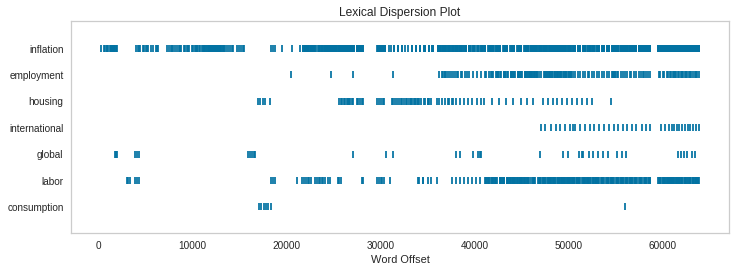

In [14]:
# Load the text data
df_dispersion = df.statements
df_dispersion = df_dispersion.T.squeeze()

# Create a list of words from the corpus text
text = [doc.split() for doc in df_dispersion]

# Choose words whose occurence in the text will be plotted
target_words = ['inflation', 'employment', 'housing', 'international', 'global', 'labor', 'consumption'] 

# Create the visualizer and draw the plot
visualizer = DispersionPlot(target_words, size=(850, 280))
visualizer.fit(text)

visualizer.poof()


In [15]:
#tsne = TSNEVisualizer()
#tsne.fit(X, y)
#tsne.show()


NameError: ignored

In [0]:
tokens = nltk.word_tokenize(raw)

#Create your bigrams
bgs = nltk.bigrams(tokens)

#compute frequency distribution for all the bigrams in the text
fdist = nltk.FreqDist(bgs)
for k,v in fdist.items():
    print k,v